In [1]:
%load_ext autoreload
%autoreload 2

*Authors: Ema Donev and dr. Ivezić*

In this notebook we tackle the portion of our stars which are RR Lyraes. We conduct extensive light curve analysis, starting from period calculation using the Lomb-Scargle periodogram. We also calculate the ratio of periods between LINEAR and ZTF, as well as the mean period used later for analysis. From the periodogram we conduct additional analysis of local peak indication of the Blazhko effect. We also fit light curves based on their period and save statistical metrics such as chi2 and rms. We use this data later for BE candidate analysis.

In [2]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML & Astropy
from astroML.datasets import fetch_LINEAR_sample
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample
from astroML.datasets import fetch_LINEAR_geneva
from astropy.timeseries import TimeSeries
from astropy.table import Table
from astroML.time_series import MultiTermFit

# ZTF
from ztfquery import lightcurve

# Basic libraries
import random
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd
import dask.dataframe as dd 

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm
from scipy.signal import find_peaks
from array import array

In [3]:
#| code-fold: false
# CONFIG
sns.set_theme() # setting the theme for plotting
np.random.seed(42)

colors = ['#1A090D', '#D8C99B', '#D8973C', '#BD632F', '#273E47']
cmap = mcolors.ListedColormap(colors)

font = FontProperties()
font.set_family('avenir')
font.set_name('Avenir')
font.set_style('normal')
font.set_size('xx-large')

%matplotlib inline  

In [4]:
#| code-fold: false
# Importing custom libraries
# ----------------------------
sys.path.insert(0,'../src/')
from config import*
from selection import *
from blazhko_analysis import *

Loading the data!


In [26]:
#| code-fold: false
# LINEAR DATA
dataL = fetch_LINEAR_sample(data_home='../inputs') # fetching the data from astroML data library

# Methods

we used for the analysis of RR Lyrae stars.

The Lomb-Scargle method of computing the period of a variable star using light curves involves fitting multi-level sinusoidal waves to our light curve data over various trial periods, and the period with the most prominent strength or the best fit is the actual period.

This is the formula for the Lomb-Scargle periodogram:

$$P(ω)= \frac{1}{2σ^2}​*(\frac{[∑y_k cosω(t_k−τ)]^2}{∑cos^2 ω(t_k−τ)} + \frac{[∑y_k sin ω(t_k−τ)]^2}{∑ sin^2 ω(t_k−τ)})$$

We use the Lomb-Scargle periodogram because it is the most famous tool for determining the periodic variable stars' period. It combines multiple methods of analysis, with its core being in Fourier analysis, and it operates with non-uniformly spaced data, such is the nature of light curves.

### Light curve folding

**Light curve phasing or folding** is when we condense the entire timeseries of the light curve into one *phase*, or one cycle of variability. Phase is defined with the period of the light curve, as such: $$phase = \frac{time}{period} - int(\frac{time}{period})$$ This function defines the period as a value from 0 to 1 defining how far in is the star in its variability cycle. We can then adjust the `time` array using this function.

### Fitting light curves
**Light curve fitting** requires a sophisticated function which uses Fourier analysis to correctly fit a curve through light curve `time`, `mag` and `magerr` data. We can define how many terms we want our fit to have. *The more terms we use, the more complicated shapes we can graph*. The fitting is an essential part of light curve analysis, as we can then calculate the goodness of fit and monitor how that fit changes over long periods of time, like in the case of `LINEAR` and `ZTF`.

### `Chi-2 test` and `RMS scatter`

#### `RMS scatter`
RMS scatter is a statistical metric that, in this case, measures the goodness of fit versus the actuall data. It is calculated as such: $$RMS = \sqrt{\frac{1}{n}\sum^n_{i=1} x_i^2}$$

#### `Chi-2 test`
This test asseses the "goodness of fit" of light curves, by comparing the fitted values and the actual magnitude values of the light curve. The lower the chi-2 value, the better the correlation between the observed and expected values (based on some model), and the higher the chi-2 value, the poorer the correlation. At which point the value is too high or too low is determined by the statistician, based on the degrees of freedom and the nature of the data. The chi-2 value for every point of a light curve is calculated as such: $$\chi^2 = \sum{\frac{(O_i - E_i)^2}{E_i}}$$

### Periodogram analysis

write section for periodogram analysis

# Selecting RR Lyrae stars

In order to select the RR Lyrae stars, we need information about their classification type and which stars have enough datapoints for correct period calculation. We access data with the `fetch_LINEAR_geneva()` which contains additional information about the light curves in the **Geneva catalog** of the `LINEAR` variable stars.

We have calculated the periods of the RR Lyrae stars beforehand with only 3 Fourier coefficients, enough to differentiate "1 dip" and "2 dip" stars. You can find the entire code for `select_LINEAR` in the `selection.py` file.

In [6]:
#| code-fold: false
L = select_LINEAR('LINEAR_Periods_nterm3')
L.head()

,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype
0,29848,0.557009,0.557019,119.526443,46.962120,1.17,0.37,1.02,0.27,-0.254138,0.62,-0.31,-0.57,16.37,301,1
1,32086,0.569258,0.569266,119.324013,47.095505,1.36,0.52,1.17,0.31,-0.244691,0.71,-0.49,-1.00,15.02,289,1
2,50402,0.643293,0.643286,119.712975,52.149574,1.18,0.39,1.10,0.20,-0.191591,0.49,-0.29,-0.88,16.46,284,1
3,61011,0.662369,0.662376,118.491257,53.168125,0.81,0.55,1.62,0.20,-0.178900,0.69,-0.03,-1.06,14.08,274,1
4,62892,0.530772,0.530764,119.187241,53.379295,1.12,0.21,1.07,0.21,-0.275092,0.62,-0.55,-0.32,16.54,276,1


We have now selected all of the "good" `LINEAR` IDs, now we need to select the RR Lyrae stars.

We first select "1 dip stars" using the coefficient between the original (correct) and our calculated period. Since 1 dip stars are easy to calculate periods for, they should match very well (from a range from 0.99 to 1.01). However, Eclipsing Binaries do not match up well, and often times have a ratio where our calculated period is 2 times bigger than the correct one. This is the easiest way to differentiate the two.

In [7]:
#| code-fold: false
# SELECTING 1 dip STARS
# -------------------------

P_ratio = L['Porig']/L['Pnew']

L_1 = L[(P_ratio>0.99)&(P_ratio<1.01)] # where the ratio between the original (correct) and currently calculated periods are 1:1
L_1.head()

,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype
0,29848,0.557009,0.557019,119.526443,46.962120,1.17,0.37,1.02,0.27,-0.254138,0.62,-0.31,-0.57,16.37,301,1
1,32086,0.569258,0.569266,119.324013,47.095505,1.36,0.52,1.17,0.31,-0.244691,0.71,-0.49,-1.00,15.02,289,1
2,50402,0.643293,0.643286,119.712975,52.149574,1.18,0.39,1.10,0.20,-0.191591,0.49,-0.29,-0.88,16.46,284,1
3,61011,0.662369,0.662376,118.491257,53.168125,0.81,0.55,1.62,0.20,-0.178900,0.69,-0.03,-1.06,14.08,274,1
4,62892,0.530772,0.530764,119.187241,53.379295,1.12,0.21,1.07,0.21,-0.275092,0.62,-0.55,-0.32,16.54,276,1


Now, we select the *RR Lyrae* stars using the color filter values `(g-i)` and the light curve classification `(LCtype)`. 

In [8]:
#| code-fold: false
Lrrlyr = L_1[(L_1['gi']>-0.5)&(L_1['gi']<0.4)&(L_1['LCtype']>0)&(L_1['LCtype']<3)] # RR lyrae type
Lab = Lrrlyr[Lrrlyr['LCtype']==1] # RRab type
Lc = Lrrlyr[Lrrlyr['LCtype']==2] # RRc type
print(len(Lab), len(Lc))
Lrrlyr.head()

2144 566


,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype
0,29848,0.557009,0.557019,119.526443,46.962120,1.17,0.37,1.02,0.27,-0.254138,0.62,-0.31,-0.57,16.37,301,1
2,50402,0.643293,0.643286,119.712975,52.149574,1.18,0.39,1.10,0.20,-0.191591,0.49,-0.29,-0.88,16.46,284,1
4,62892,0.530772,0.530764,119.187241,53.379295,1.12,0.21,1.07,0.21,-0.275092,0.62,-0.55,-0.32,16.54,276,1
5,91437,0.674728,0.674711,120.294960,40.932457,1.18,0.24,1.09,0.37,-0.170871,0.75,-0.12,-0.93,15.39,177,1
6,95250,0.313869,0.313869,120.124542,40.656620,1.18,-0.14,0.83,0.28,-0.503252,0.55,0.14,-0.65,16.98,222,2


We now have 2710 RR Lyrae stars from the `LINEAR` database. We can differentiate them further into *RR Lyrae AB* and *RR Lyrae C* types, but this can be done later (we just have to conserve the `LCtype` column).

# Complete analysis of RR Lyrae stars

Finally, we are able to conduct extensive analysis of RR Lyrae stars, so we can later search for Blazhko stars. All of the necessary functions for this section can be found in `blazhko_analysis.py`.

In [12]:
#| code-fold: false
# CONFIG BEFORE BIG RUN

lc_type = Lrrlyr['LCtype'].to_numpy()
rectascension = Lrrlyr['ra'].to_numpy() # list of rectascension coordinates
declination = Lrrlyr['dec'].to_numpy() # list of declination coordinates

end = 'FINAL_FINAL_FULL'

## Accessing ZTF data - creating a comprehensive dataset

In [11]:
ZTF_data_lc = []

for i in tqdm(range(len(Lids))):
    Lid = Lids[i]
    ra = rectascension[i]
    dec = declination[i]
    ZTFdata = getZTFlightcurve(ra, dec)
    ZTF_data_lc.append((Lid, ZTFdata))

    if i%10==0:
        ZTF_data_lca = np.array(ZTF_data_lc, dtype=object)
        np.save("../outputs/ZTF_dataset_"+end+".npy", ZTF_data_lca, allow_pickle=True)

ZTF_data_lca = np.array(ZTF_data_lc, dtype=object)
np.save("../outputs/ZTF_dataset_"+end+".npy", ZTF_data_lca, allow_pickle=True)

100%|██████████| 2710/2710 [15:08:30<00:00, 20.11s/it]        


In [9]:
ZTF_data_lc = np.load('../outputs/ZTF_dataset_full.npy', allow_pickle=True)
ZTF_data_lc[0]

array([29848,              mjd        mag    magerr  catflags filtercode
              0   58234.145590  16.602722  0.013815         0         zg
              1   58427.382442  16.502769  0.013371         0         zg
              2   58430.365961  16.806061  0.014901         0         zg
              3   58438.437373  16.230679  0.012411         0         zg
              4   58439.407025  16.335060  0.012739         0         zg
              ..           ...        ...       ...       ...        ...
              88  58856.199583  16.114397  0.012111         0         zr
              89  58859.293299  16.445725  0.013452         0         zr
              90  58859.293750  16.512478  0.013793         0         zr
              91  58860.268113  16.387852  0.013178         0         zr
              92  58860.268576  16.403954  0.013253         0         zr

              [82 rows x 5 columns]                                     ],
      dtype=object)

In [10]:
ztfdata = dict(ZTF_data_lc)
Lids = list(ztfdata.keys())
ztfdata[29848]

,mjd,mag,magerr,catflags,filtercode
0,58234.145590,16.602722,0.013815,0,zg
1,58427.382442,16.502769,0.013371,0,zg
2,58430.365961,16.806061,0.014901,0,zg
3,58438.437373,16.230679,0.012411,0,zg
4,58439.407025,16.335060,0.012739,0,zg
...,...,...,...,...,...
88,58856.199583,16.114397,0.012111,0,zr
89,58859.293299,16.445725,0.013452,0,zr
90,58859.293750,16.512478,0.013793,0,zr
91,58860.268113,16.387852,0.013178,0,zr


# RR Lyrae analysis

We now conduct full light curve analysis via the `ZTF` data we extracted beforehand. 

In [ ]:
test = len(Lids)
ZTF_data_best = []
periodograms = []
lc_analysis = {}
fits = []

if os.path.isfile('../outputs/LC_ANALYSIS_'+end+'.csv'):
    print('Loading data!')
    lightcurve_analysis = pd.read_csv('../outputs/LC_ANALYSIS_'+end+'.csv')
    periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
    fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
    ztfdata = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)
else:
    for i in tqdm(range(test)):
        lc_analysis, periodograms, fits, ZTF_data_best = RR_lyrae_analysis(end, i, Lids, ztfdata, lc_analysis, ZTF_data_best, fits, periodograms)
        
        if i%10==0:
            # save dictionary to pkl file
            with open('../outputs/lc_analysis_'+end+'.pkl', 'wb') as fp:
                pickle.dump(lc_analysis, fp)
            with open("../outputs/periodograms_"+end+".pkl", "wb") as x:
                pickle.dump(periodograms, x)
            FITS = np.array(fits, dtype=object)
            np.save("../outputs/fits_"+end+".npy", FITS, allow_pickle=True)
            ZTF_data_lca = np.array(ZTF_data_best, dtype=object)
            np.save("../outputs/ztf_data_filter"+end+".npy", ZTF_data_lca, allow_pickle=True)
    # save dictionary to pkl file
    with open('../outputs/lc_analysis_'+end+'.pkl', 'wb') as fp:
        pickle.dump(lc_analysis, fp)
    with open("../outputs/periodograms_"+end+".pkl", "wb") as x:
        pickle.dump(periodograms, x)
    FITS = np.array(fits, dtype=object)
    np.save("../outputs/fits_"+end+".npy", FITS, allow_pickle=True)
    ZTF_data_lca = np.array(ZTF_data_best, dtype=object)
    np.save("../outputs/ztf_data_filter"+end+".npy", ZTF_data_lca, allow_pickle=True)

In [25]:
#lightcurve_analysis = pd.read_csv('../outputs/LC_ANALYSIS_FINALFINAL_FINAL_FULL.csv')
periodogr = pickle.load(open("../outputs/periodograms_FINAL_FINAL_FULL.pkl", "rb"))
fits = np.load("../outputs/fits_FINAL_FINAL_FULL.npy", allow_pickle=True)
ztfdata = np.load("../outputs/ztf_data_filterFINAL_FINAL_FULL.npy", allow_pickle=True)

In [ ]:
#cols = ['Plinear', 'Pztf', 'Pmean', 'Pratio', 'NdataLINEAR', 
        'L_rms', 'L_chi2dof', 'L_chi2dofR', 
        'Lmean_rms', 'Lmean_chi2dof', 'Lmean_chi2dofR', 'Lmmax', 'Lampl', 
        'NdataZTF', 'Z_rms', 'Zchi2dof', 
        'Zchi2dofR', 'Zmean_rms', 'Zmean_chi2dof', 'Zmean_chi2dofR', 
        'Zmmax', 'Zampl',
        'MainPeakL', 'BlazhkoPeakL', 'BlazhkoPeriodL','BpowerRatioL','BsignificanceL',
        'MainPeakZ', 'BlazhkoPeakZ', 'BlazhkoPeriodZ', 'BpowerRatioZ', 'BsignificanceZ']
#LC_ANALYSIS = pd.DataFrame.from_dict(lc_analysis, orient='index', columns=cols)
#LC_ANALYSIS.index.name='LINEAR id'
#LC_ANALYSIS = LC_ANALYSIS.drop(["what"], axis=1)
#LC_ANALYSIS = LC_ANALYSIS.drop(["what 2"], axis=1)
#LC_ANALYSIS = LC_ANALYSIS.reset_index()
#LC_ANALYSIS.to_csv("../outputs/LC_ANALYSIS_FINAL"+end+".csv", index=False)

In [17]:
LC_ANALYSIS.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_rms,L_chi2dof,L_chi2dofR,Lmean_rms,...,MainPeakL,BlazhkoPeakL,BlazhkoPeriodL,BpowerRatioL,BsignificanceL,MainPeakZ,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ


---

In [21]:
lightcurve_analysis = pd.read_csv('../outputs/LC_ANALYSIS_FINALFINAL_FINAL_FULL.csv')

In [24]:
lightcurve_analysis['LC_type'] = lc_type
lightcurve_analysis.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_rms,L_chi2dof,L_chi2dofR,Lmean_rms,...,BlazhkoPeakL,BlazhkoPeriodL,BpowerRatioL,BsignificanceL,MainPeakZ,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,LC_type
0,29848,0.557020,0.557035,0.5570,1.0,301,0.000000,0.0,0.0,0.000000,...,1.832831,26.620524,0.045499,7.483869,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,50402,0.643303,0.643294,0.6433,1.0,284,0.105976,0.6,0.7,0.107611,...,1.622344,14.735136,0.077603,7.194603,1.912758,1.916053,303.490137,0.014553,2.074831,1
2,62892,0.530776,0.530786,0.5308,1.0,276,0.108535,1.1,0.9,0.131104,...,1.951914,14.731880,0.065840,7.123299,1.002304,1.025584,42.955326,0.061844,4.772949,1
3,91437,0.674733,0.674737,0.6747,1.0,177,0.040739,2.8,1.3,0.073285,...,1.549828,14.757969,0.081603,4.427005,1.482062,1.541012,16.963528,0.032789,5.426679,1
4,95250,0.313870,0.313877,0.3139,1.0,222,0.162522,0.8,0.8,0.865595,...,3.256529,14.184397,0.037702,9.998570,1.061979,1.092869,32.372936,0.096901,8.201794,2


In [23]:
lightcurve_analysis.to_csv('../outputs/LC_ANALYSIS_FINALFINAL_FINAL_FULL.csv', index=False)

In [29]:
L1 = fits[0][1][0]
L2 = fits[0][1][2]
Lid = lightcurve_analysis['LINEAR id'].to_numpy()[0]

KeyError: 'dP'

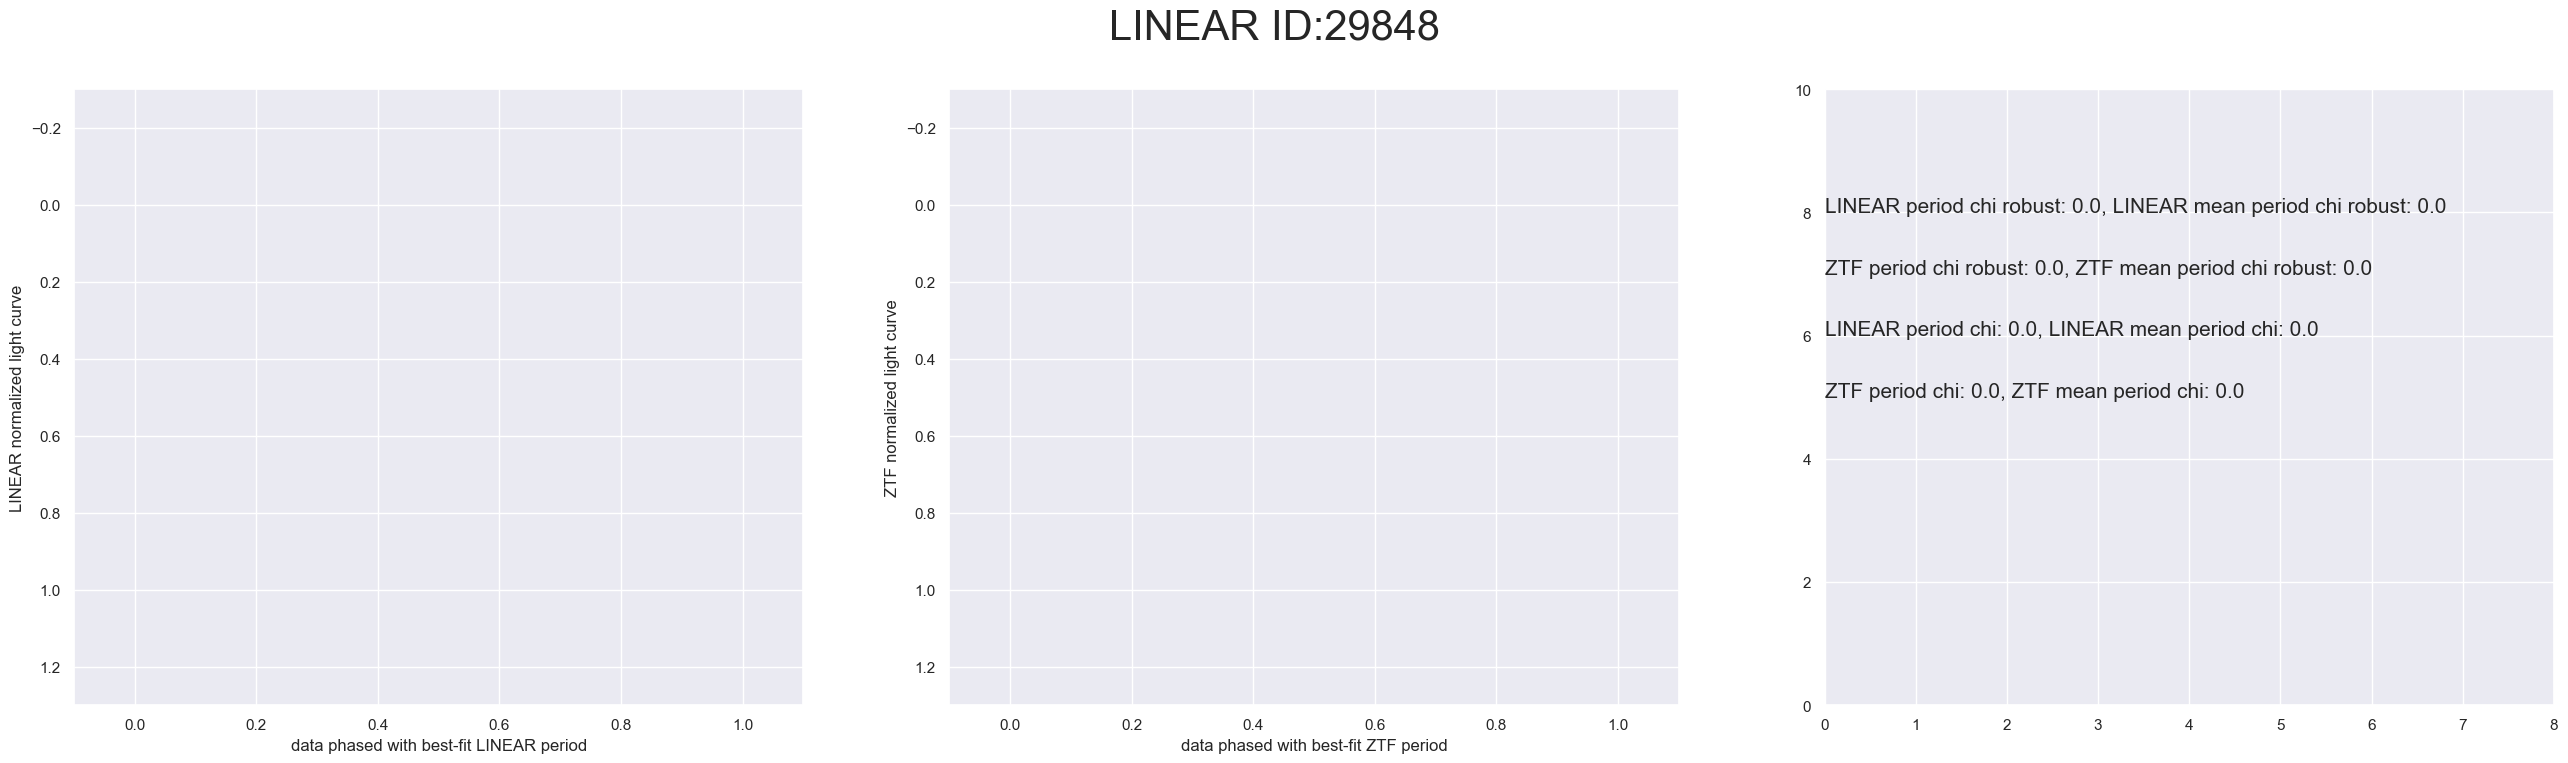

In [30]:
makeLCplot_info(L1, L2, lightcurve_analysis, 0, Lid, dataL)